# LDA

In [218]:
import pandas as pd
import numpy as np

In [219]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
import os
import pickle


## Demographic data calling

In [220]:
# call the original data again
df = pd.read_csv('~/knowledge-explore/data/processed_data/reference_dataset_v1.csv')

In [221]:
df.head(3)

,Unnamed: 0,problem_id,participant_id,DAT,CRT2,CURIOSITY_SCORE,AGE,GENDER,EDUCATION,EMPLOYMENT,...,POLITICAL,CLIMATE,COVID,NEWS,MEDIA,RELATION_KNOWLEDGE,RELATION_INTEREST,RELATION_CONCERN,ideas,emb_ideas
0,0,Q1,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,2,4,4,"['vaccination schemes in these areas', 'increa...","[[-0.011656875722110271, -0.019422005861997604..."
1,1,Q2,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,3,5,5,['equal pay for women and men in the same role...,"[[-0.0034376916009932756, 0.006209875456988811..."
2,2,Q3,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,3,5,5,"['look into conservation plans ', 'ensure poac...","[[0.03516001999378204, -0.004544570576399565, ..."


In [222]:
df = df.rename(columns = {'participant_id': 'PARTICIPANT_ID'})
df = df.set_index('PARTICIPANT_ID')

In [223]:
demos = df[['AGE', 'GENDER', 'EDUCATION', 'EMPLOYMENT', 'INCOME', 'POLITICAL', 'DAT', 'CRT2']]

In [224]:
# Check for duplicate indices
duplicates = demos.index.duplicated()

# keep only the first occurrence of each participant_id (remove duplicates)
demos.drop_duplicates(keep='first', inplace=True)

# Display the modified DataFrame
print("\nDataFrame with unique participant_id:")
print(demos)


DataFrame with unique participant_id:
                AGE  GENDER  EDUCATION  EMPLOYMENT  INCOME  POLITICAL  \
PARTICIPANT_ID                                                          
00278            24       1          5           1       3          2   
0068d            74       1          2           7       2          4   
00f13            43       1          4           1       3          3   
01cb6            56       3          2           8       1          1   
02670            25       1          5           1       2          2   
...             ...     ...        ...         ...     ...        ...   
f92a4            35       1          5           1       3          3   
f9fd8            50       1          4           8       2          2   
fb2a2            38       1          2           8       1          3   
fb9c4            21       1          4           8       3          2   
ff2bf            67       1          2           7       2          4   

           

/tmp/ipykernel_2217518/256376826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demos.drop_duplicates(keep='first', inplace=True)


## Dataset: Question 2


In [225]:
q2 = pd.read_json('~/thesis/data/processed_data/knowledge_q2_lemmatized.jsonl', orient='records', lines = True)

In [226]:
q2 = q2.groupby('participant_id')['answer'].apply(lambda x: ' '.join(x)).reset_index()
q2.fillna('', inplace=True)

In [227]:
q2.head()

,participant_id,answer
0,00278,equal pay woman men role ensure woman voice he...
1,0068d,ensure equal salary paid people regardless sex...
2,00f13,ensuring equal pay ensuring fair 5050 split me...
3,01cb6,employ equal number target desired gender impr...
4,02670,hire woman nonbinary people organise programme...


In [228]:
index_save = q2['participant_id']

In [229]:
# Step 4: Vectorize the concatenated responses using BoW
vectorizer = CountVectorizer(max_features=1000)
vectors2 = vectorizer.fit_transform(q2['answer']).toarray()

In [230]:
# Step 5: Create a DataFrame from the vectors
final_df = pd.DataFrame(vectors2, index=q2['participant_id'])

In [231]:
# Step 6: Convert final_df to a Gensim-compatible corpus format
corpus = [list(enumerate(doc)) for doc in final_df.values]

# Create a Gensim Dictionary using the vocabulary from the vectorizer
vocab = vectorizer.get_feature_names_out()
dummy_dict = corpora.Dictionary()
dummy_dict.token2id = {word: idx for idx, word in enumerate(vocab)}
dummy_dict.id2token = {idx: word for idx, word in enumerate(vocab)}

## Coherence Score to define num_topics parameter

In [232]:
from gensim.models import CoherenceModel

### warning: it takes long. Make sure it is needed.

In [235]:
# Function to compute coherence score
def compute_coherence_score(corpus, dictionary, texts, num_topics):
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Prepare texts for coherence computation
texts = [doc.split() for doc in q2['answer']]  # Assuming you have preprocessed texts

# Evaluate coherence score for different numbers of topics
num_topics_list = range(2, 11)
coherence_scores = []

for num_topics in num_topics_list:
    coherence_score = compute_coherence_score(corpus, dummy_dict, texts, num_topics)
    coherence_scores.append(coherence_score)
    print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')

Number of topics: 2, Coherence Score: 0.27435127056864994
Number of topics: 3, Coherence Score: 0.31090839365576306
Number of topics: 4, Coherence Score: 0.25239989237944416
Number of topics: 5, Coherence Score: 0.28214300982840884
Number of topics: 6, Coherence Score: 0.2737650485957836
Number of topics: 7, Coherence Score: 0.25451981697887255
Number of topics: 8, Coherence Score: 0.27775930745763044
Number of topics: 9, Coherence Score: 0.26138033472273536
Number of topics: 10, Coherence Score: 0.26354256273388554


In [236]:
import matplotlib.pyplot as plt

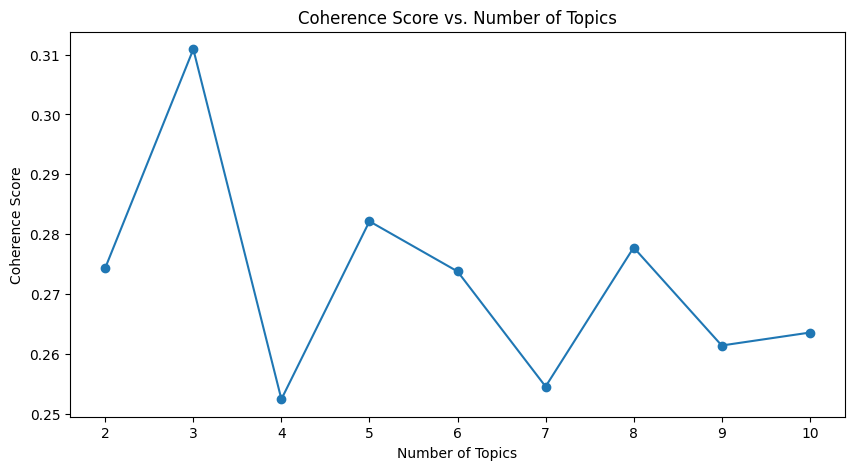

In [237]:
# Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()


In [265]:
# Step 7: Train the LDA model on the corpus
num_topics = 3  # Adjust based on your needs
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dummy_dict, passes=10)

In [266]:
# Step 8: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dummy_dict)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, '/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics)+'.html')

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.074624 -0.029664       1        1  37.700379
2     -0.065696 -0.043661       2        1  33.598723
0     -0.008928  0.073325       3        1  28.700898, topic_info=            Term        Freq       Total Category  logprob  loglift
977        woman  119.000000  119.000000  Default  30.0000  30.0000
497          men   68.000000   68.000000  Default  29.0000  29.0000
791        staff   30.000000   30.000000  Default  28.0000  28.0000
479         make   61.000000   61.000000  Default  27.0000  27.0000
317        equal  115.000000  115.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
977        woman   13.664678  119.589893   Topic3  -4.7014  -0.9210
313       ensure    9.482939   43.543848   Topic3  -5.0667  -0.2760
464        leave    8.508914   35.458031   Topic3  -5.1751  -0.1790
536  opportunity    7.965373   30.055212   Topic3  -5.2411  -0.0797
497          men    8.061237   68.722822   Topic3  -5.2291  -0.8948

[232 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         2  0.895270    ability
19        1  0.785377    account
63        1  0.299712     amount
63        2  0.199808     amount
63        3  0.599423     amount
...     ...       ...        ...
985       3  0.578602    working
987       1  0.229442  workplace
987       2  0.280430  workplace
987       3  0.509872  workplace
998       1  0.785377       zero

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

## Connect the demographic information to the LDA results

In [267]:
# extract topic distribution for each document
topic_distributions = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]
topic_df = pd.DataFrame([{i: prob for i, prob in doc} for doc in topic_distributions]).fillna(0)

In [268]:
# Assign topics to each document
most_probable_topics =  [max(topic, key=lambda x: x[1])[0] for topic in topic_distributions]

In [269]:
community= pd.DataFrame(most_probable_topics, index = index_save, columns = ['community'])

In [270]:
community

,community
participant_id,
00278,1
0068d,2
00f13,1
01cb6,0
02670,0
...,...
f92a4,2
f9fd8,2
fb2a2,2


In [271]:
demos.head()

,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2,id
PARTICIPANT_ID,,,,,,,,,
00278,24,1,5,1,3,2,74.104969,3,00278
0068d,74,1,2,7,2,4,79.882640,2,0068d
00f13,43,1,4,1,3,3,77.948290,3,00f13
01cb6,56,3,2,8,1,1,78.969095,2,01cb6
02670,25,1,5,1,2,2,83.311323,1,02670


In [272]:
# Participants_ID converting from integer(index) to the original id from saved index.
final_df.index = index_save 
topic_df.index = index_save

In [273]:
## filter only the indices exist in demos for the clustering

final_df = final_df.loc[final_df.index.isin(demos.index)]
topic_df = topic_df.loc[topic_df.index.isin(demos.index)]
community = community.loc[community.index.isin(demos.index)]

community

,community
participant_id,
00278,1
0068d,2
00f13,1
01cb6,0
02670,0
...,...
f92a4,2
f9fd8,2
fb2a2,2


demos and the question2 are coherent.

In [274]:
topic_df

,0,1,2
participant_id,,,
00278,0.019016,0.962228,0.018756
0068d,0.016086,0.016367,0.967547
00f13,0.016359,0.968195,0.015445
01cb6,0.941856,0.027437,0.030707
02670,0.973980,0.012651,0.013369
...,...,...,...
f92a4,0.029511,0.309687,0.660802
f9fd8,0.021433,0.020743,0.957824
fb2a2,0.039373,0.037932,0.922695


In [275]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
participant_id,,,,,,,,,,,,,,,,,,,,,
00278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0068d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00f13,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01cb6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
02670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f92a4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f9fd8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fb2a2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
community

,community
participant_id,
00278,1
0068d,2
00f13,1
01cb6,0
02670,0
...,...
f92a4,2
f9fd8,2
fb2a2,2


### Make two different dataframe for the analysis: Topic == community 
* merged_df for the topic distributions
* community_df for the topic assignment

In [277]:
# make a common column for the merge
topic_df['id'] = topic_df.index
community['id'] = community.index
demos['id'] = demos.index

# merged_df: for the topic distributions
merged_df = pd.merge(topic_df, demos, on = 'id')
# community_df: for the community label. Here topic == community
community_df = pd.merge(community, demos, on = 'id')

/tmp/ipykernel_2217518/912597800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demos['id'] = demos.index


In [278]:
community_df.index = community_df['id']

In [279]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [280]:
# column name changed for the readability 
merged_df = merged_df.rename(columns = {0: 'community0', 1: 'community1', 2: 'community2'})
merged_df.head()

,community0,community1,community2,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
0,0.019016,0.962228,0.018756,00278,24,1,5,1,3,2,74.104969,3
1,0.016086,0.016367,0.967547,0068d,74,1,2,7,2,4,79.882640,2
2,0.016359,0.968195,0.015445,00f13,43,1,4,1,3,3,77.948290,3
3,0.941856,0.027437,0.030707,01cb6,56,3,2,8,1,1,78.969095,2
4,0.973980,0.012651,0.013369,02670,25,1,5,1,2,2,83.311323,1


### Create the community dictionary

### Age

In [281]:
# Initialize an empty dictionary to store DataFrames
community_dfs_age = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_age[label] = community_df[community_df['community'] == label][['AGE']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_age[0]}")

DataFrame for community 0:
       AGE
id        
01cb6   56
02670   25
06419   59
07089   29
0a0eb   20
...    ...
f4060   63
f4420   26
f4fb5   52
f6145   63
fb9c4   21

[130 rows x 1 columns]


### DAT

In [282]:
# Initialize an empty dictionary to store DataFrames
community_dfs_dat= {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_dat[label] = community_df[community_df['community'] == label][['DAT']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_dat[0]}")

DataFrame for community 0:
             DAT
id              
01cb6  78.969095
02670  83.311323
06419  73.710990
07089  74.844477
0a0eb  75.916909
...          ...
f4060  81.732260
f4420  74.792558
f4fb5  80.567095
f6145  81.567807
fb9c4  83.133171

[130 rows x 1 columns]


### CRT

In [283]:
# Initialize an empty dictionary to store DataFrames
community_dfs_crt = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_crt[label] = community_df[community_df['community'] == label][['CRT2']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_crt[0]}")

DataFrame for community 0:
       CRT2
id         
01cb6     2
02670     1
06419     3
07089     3
0a0eb     3
...     ...
f4060     2
f4420     2
f4fb5     2
f6145     1
fb9c4     1

[130 rows x 1 columns]


### Political leaning

In [284]:
# Initialize an empty dictionary to store DataFrames
community_dfs_politics = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_politics[label] = community_df[community_df['community'] == label][['POLITICAL']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_politics[0]}")

DataFrame for community 0:
       POLITICAL
id              
01cb6          1
02670          2
06419          2
07089          2
0a0eb          2
...          ...
f4060          3
f4420          1
f4fb5          2
f6145          2
fb9c4          2

[130 rows x 1 columns]


### Education

In [285]:
# Initialize an empty dictionary to store DataFrames
community_dfs_education = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_education[label] = community_df[community_df['community'] == label][['EDUCATION']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_education[0]}")

DataFrame for community 0:
       EDUCATION
id              
01cb6          2
02670          5
06419          3
07089          4
0a0eb          4
...          ...
f4060          3
f4420          2
f4fb5          3
f6145          2
fb9c4          4

[130 rows x 1 columns]


### Income

In [286]:
# Initialize an empty dictionary to store DataFrames
community_dfs_income = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_income[label] = community_df[community_df['community'] == label][['INCOME']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_income[0]}")

DataFrame for community 0:
       INCOME
id           
01cb6       1
02670       2
06419       1
07089       1
0a0eb       3
...       ...
f4060       2
f4420       3
f4fb5       1
f6145       1
fb9c4       3

[130 rows x 1 columns]


### Gender

In [287]:
# Initialize an empty dictionary to store DataFrames
community_dfs_gender = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_gender[label] = community_df[community_df['community'] == label][['GENDER']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_gender[0]}")

DataFrame for community 0:
       GENDER
id           
01cb6       3
02670       1
06419       3
07089       3
0a0eb       3
...       ...
f4060       1
f4420       3
f4fb5       3
f6145       1
fb9c4       1

[130 rows x 1 columns]


### Job

In [288]:
# Initialize an empty dictionary to store DataFrames
community_dfs_job = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_job[label] = community_df[community_df['community'] == label][['EMPLOYMENT']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_job[0]}")

DataFrame for community 0:
       EMPLOYMENT
id               
01cb6           8
02670           1
06419           4
07089           8
0a0eb           6
...           ...
f4060           2
f4420           1
f4fb5           8
f6145           7
fb9c4           8

[130 rows x 1 columns]


## Statistical Analysis

In [289]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.multivariate.manova as MANOVA

## ANOVA: use the community label

### Age

In [290]:
for label, df_age in community_dfs_age.items():
    print(f"*community_{label} in age")
    print("how many:", len(df_age))
    print("mean:", np.mean(df_age['AGE']))
    print("variance:", np.var(df_age['AGE']))
    print("std:", np.std(df_age['AGE']))
    print()

*community_0 in age
how many: 130
mean: 44.823076923076925
variance: 216.86869822485207
std: 14.726462515650256

*community_1 in age
how many: 47
mean: 43.5531914893617
variance: 264.92802172928924
std: 16.27660965094664

*community_2 in age
how many: 121
mean: 47.77685950413223
variance: 261.4626050133188
std: 16.16980534865274



## Levene's Test

In [291]:
import scipy.stats as stats

In [292]:
# Extract age data from each community's DataFrame
age_groups = [community_dfs_age[label]['AGE'].values for label in range(num_topics)]

# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(*age_groups)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")

Levene's Test Statistic: 0.8670692557648558
P-value: 0.4212492010153748
Fail to reject the null hypothesis. Variances are likely homogeneous.


## ANOVA

In [293]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*age_groups)

# Print the results
print("ANOVA F-Statistic:", f_statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of significant differences in means.")
else:
    print("Fail to reject the null hypothesis. Means are likely equal across groups.")

ANOVA F-Statistic: 1.7019909388406993
P-value: 0.18410551047182241
Fail to reject the null hypothesis. Means are likely equal across groups.


### Post-hoc analysis: standardized residuals

In [296]:
community_df.head()

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1


In [297]:
df_age = community_df[['AGE', 'community']]

In [298]:
df_age

,AGE,community
id,,
00278,24,1
0068d,74,2
00f13,43,1
01cb6,56,0
02670,25,0
...,...,...
f92a4,35,2
f9fd8,50,2
fb2a2,38,2


In [300]:
# make the dataframe only with the age. 

# Calculate the group means
group_means = df_age.groupby('community')['AGE'].mean()

# Calculate residuals for each observation
df_age['residual'] = df_age.apply(lambda row: row['AGE'] - group_means[row['community']], axis=1)

# Calculate the standard deviation of the residuals
residual_std = np.std(df_age['residual'], ddof=1)

# Calculate standardized residuals
df_age['standardized_residual'] = df_age['residual'] / residual_std

# Display standardized residuals by group
print("\nStandardized Residuals by Group:")
for group, data in df_age.groupby('community'):
    print(f"\nGroup {group}:")
    print(data[['AGE', 'residual', 'standardized_residual']].head())  # Show top few rows for each group

# Summary statistics of standardized residuals by group
print("\nSummary of Standardized Residuals by Group:")
print(df_age.groupby('community')['standardized_residual'].describe())


Standardized Residuals by Group:

Group 0:
       AGE   residual  standardized_residual
id                                          
01cb6   56  11.176923               0.716452
02670   25 -19.823077              -1.270678
06419   59  14.176923               0.908754
07089   29 -15.823077              -1.014275
0a0eb   20 -24.823077              -1.591183

Group 1:
       AGE   residual  standardized_residual
id                                          
00278   24 -19.553191              -1.253378
00f13   43  -0.553191              -0.035460
08238   24 -19.553191              -1.253378
0fd67   65  21.446809               1.374761
1ff0f   60  16.446809               1.054256

Group 2:
       AGE  residual  standardized_residual
id                                         
0068d   74  26.22314               1.680929
0ac65   67  19.22314               1.232222
0af61   74  26.22314               1.680929
0b262   65  17.22314               1.104020
0e30c   33 -14.77686              -0.94721

/tmp/ipykernel_2217518/2007832366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['residual'] = df_age.apply(lambda row: row['AGE'] - group_means[row['community']], axis=1)
/tmp/ipykernel_2217518/2007832366.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['standardized_residual'] = df_age['residual'] / residual_std


**Interpretation on the standardized residuals**
* mean: all communities' are centered on 0 as it is standardized. 
* standard deviations(std): Groups with higher value suggests some observations in these groups are more atypical compared to others. Here, the deviations are alike between communities. 
* min and max: not extreme range differences are found from the standardized residuals. 

## Chi-Square Test

### First, check the expected frequencies
* It is supposed to be >= 5 every cell in contingency_table.

### Political leaning

In [301]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [302]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['POLITICAL'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
POLITICAL            
1          17   3  13
2          43  24  33
3          50  15  53
4          15   4  19
5           5   1   3


In [303]:
contingency_table

community,0,1,2
POLITICAL,,,
1,17,3,13
2,43,24,33
3,50,15,53
4,15,4,19
5,5,1,3


In [304]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[14.39597315  5.20469799 13.39932886]
 [43.62416107 15.77181208 40.60402685]
 [51.47651007 18.61073826 47.91275168]
 [16.57718121  5.99328859 15.4295302 ]
 [ 3.9261745   1.41946309  3.65436242]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


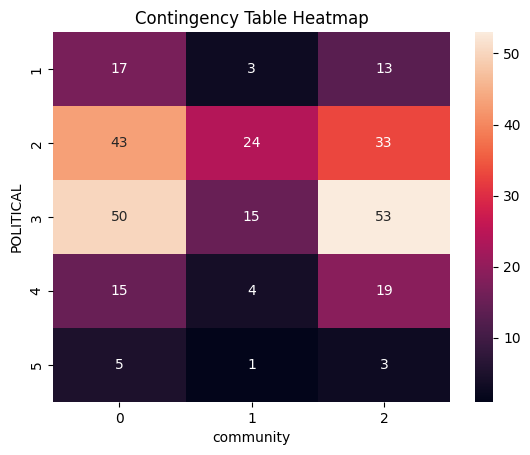

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [306]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    10.5995
Degrees of Freedom:       8
p-value:                  2.2544e-01

Expected Frequencies (rounded):
community      0      1      2
POLITICAL                     
1          14.40   5.20  13.40
2          43.62  15.77  40.60
3          51.48  18.61  47.91
4          16.58   5.99  15.43
5           3.93   1.42   3.65


* result: no significant difference


### Influence of a label on the chi-square test: residuals calculations

In [307]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    10.5995
Degrees of Freedom:       8
p-value:                  2.2544e-01

Expected Frequencies (rounded):
community      0      1      2
POLITICAL                     
1          14.40   5.20  13.40
2          43.62  15.77  40.60
3          51.48  18.61  47.91
4          16.58   5.99  15.43
5           3.93   1.42   3.65

Standardized Residuals:
community     0     1     2
POLITICAL                  
1          0.69 -0.97 -0.11
2         -0.09  2.07 -1.19
3         -0.21 -0.84  0.73
4         -0.39 -0.81  0.91
5          0.54 -0.35 -0.34

Extreme Standardized Residuals (|value| > 2):
community   0         1   2
POLITICAL                  
2         NaN  2.071874 NaN


**Result**:
* The distribution of **political leaning** is not significantly different across the communities.
* There is one extreme standardized residual, Political label 2 on the Community 1, which is overrepresented against the other Political label within the community. 

### Education

In [308]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [309]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['EDUCATION'], community_df['community'])

# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    1.4590
Degrees of Freedom:       8
p-value:                  9.9337e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          34.03  12.30  31.67
3          23.56   8.52  21.93
4          47.11  17.03  43.85
5          24.43   8.83  22.74
6           0.87   0.32   0.81


In [310]:
contingency_table_filtered = contingency_table.loc[[2,3,4,5]]

In [311]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    1.0785
Degrees of Freedom:       6
p-value:                  9.8246e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          33.99  12.39  31.62
3          23.53   8.57  21.89
4          47.07  17.15  43.78
5          24.41   8.89  22.70


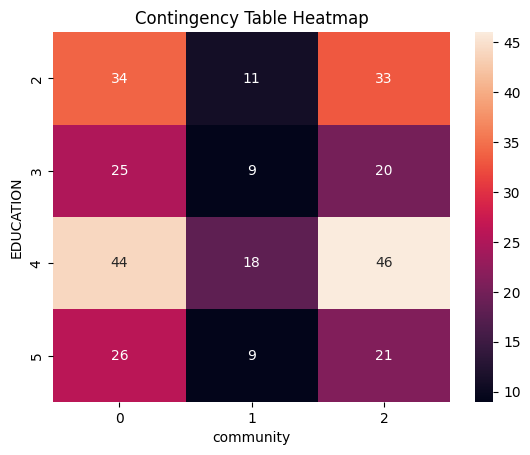

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table_filtered, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

**Result**: It says, the educationn shows no significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [314]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    1.0785
Degrees of Freedom:       6
p-value:                  9.8246e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          33.99  12.39  31.62
3          23.53   8.57  21.89
4          47.07  17.15  43.78
5          24.41   8.89  22.70

Standardized Residuals:
community     0     1     2
EDUCATION                  
2          0.00 -0.39  0.25
3          0.30  0.15 -0.40
4         -0.45  0.21  0.33
5          0.32  0.04 -0.36

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result**
* There is no extreme residuals found between the community 0, 1, 2. 

### Gender

In [315]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [316]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['GENDER'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
GENDER               
1          63  21  67
2           0   0   1
3          67  25  53
5           0   1   0


In [317]:
contingency_table

community,0,1,2
GENDER,,,
1,63,21,67
2,0,0,1
3,67,25,53
5,0,1,0


In [318]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[65.87248322 23.81543624 61.31208054]
 [ 0.43624161  0.15771812  0.40604027]
 [63.25503356 22.86912752 58.87583893]
 [ 0.43624161  0.15771812  0.40604027]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


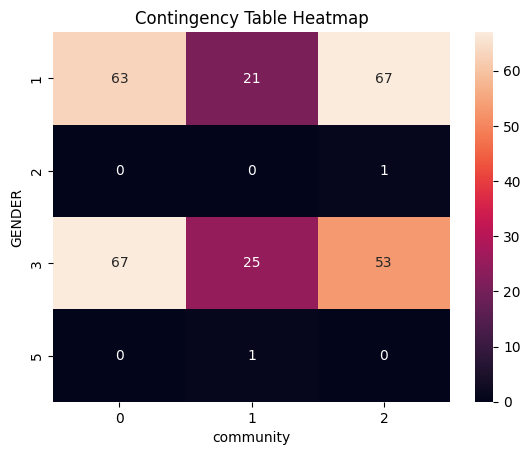

In [319]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [320]:
contingency_table_filtered = contingency_table.loc[[1,3]]

In [321]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    1.9834
Degrees of Freedom:       2
p-value:                  3.7094e-01

Expected Frequencies (rounded):
community      0      1      2
GENDER                        
1          66.32  23.47  61.22
3          63.68  22.53  58.78


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [323]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    1.9834
Degrees of Freedom:       2
p-value:                  3.7094e-01

Expected Frequencies (rounded):
community      0      1      2
GENDER                        
1          66.32  23.47  61.22
3          63.68  22.53  58.78

Standardized Residuals:
community     0     1     2
GENDER                     
1         -0.41 -0.51  0.74
3          0.42  0.52 -0.75

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result:**: 
* Residuals: needs to be filled.

### INCOME

In [324]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [325]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['INCOME'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
INCOME               
1          36   6  32
2          44  21  49
3          25  12  22
4          20   6  14
5           5   2   4


In [326]:
contingency_table

community,0,1,2
INCOME,,,
1,36,6,32
2,44,21,49
3,25,12,22
4,20,6,14
5,5,2,4


In [327]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[32.28187919 11.67114094 30.04697987]
 [49.73154362 17.97986577 46.2885906 ]
 [25.73825503  9.30536913 23.95637584]
 [17.44966443  6.30872483 16.24161074]
 [ 4.79865772  1.73489933  4.46644295]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


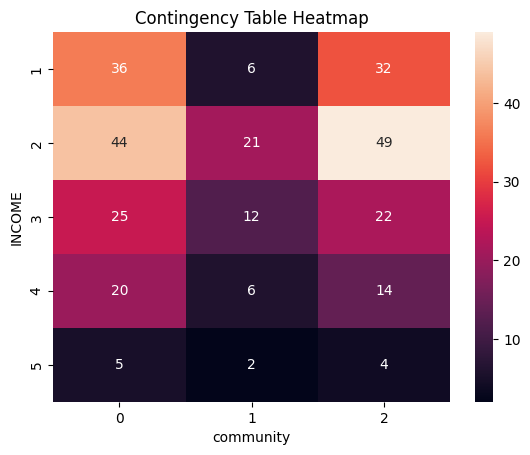

In [328]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [329]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    6.3937
Degrees of Freedom:       8
p-value:                  6.0322e-01

Expected Frequencies (rounded):
community      0      1      2
INCOME                        
1          32.28  11.67  30.05
2          49.73  17.98  46.29
3          25.74   9.31  23.96
4          17.45   6.31  16.24
5           4.80   1.73   4.47


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [331]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    6.3937
Degrees of Freedom:       8
p-value:                  6.0322e-01

Expected Frequencies (rounded):
community      0      1      2
INCOME                        
1          32.28  11.67  30.05
2          49.73  17.98  46.29
3          25.74   9.31  23.96
4          17.45   6.31  16.24
5           4.80   1.73   4.47

Standardized Residuals:
community     0     1     2
INCOME                     
1          0.65 -1.66  0.36
2         -0.81  0.71  0.40
3         -0.15  0.88 -0.40
4          0.61 -0.12 -0.56
5          0.09  0.20 -0.22

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


### Employment

In [332]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,1,00278,24,1,5,1,3,2,74.104969,3
0068d,2,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,0,01cb6,56,3,2,8,1,1,78.969095,2
02670,0,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,2,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,2,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,2,fb2a2,38,1,2,8,1,3,78.420482,0


In [333]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['EMPLOYMENT'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community    0   1   2
EMPLOYMENT            
1           50  16  44
2           20   9  12
3            7   2   4
4           17   8  18
5            9   2   5
6            8   4   6
7           13   6  23
8            6   0   9


In [334]:
contingency_table

community,0,1,2
EMPLOYMENT,,,
1,50,16,44
2,20,9,12
3,7,2,4
4,17,8,18
5,9,2,5
6,8,4,6
7,13,6,23
8,6,0,9


In [335]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[47.98657718 17.34899329 44.66442953]
 [17.88590604  6.46644295 16.64765101]
 [ 5.67114094  2.05033557  5.27852349]
 [18.75838926  6.78187919 17.45973154]
 [ 6.97986577  2.52348993  6.4966443 ]
 [ 7.85234899  2.83892617  7.30872483]
 [18.32214765  6.62416107 17.05369128]
 [ 6.54362416  2.36577181  6.09060403]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


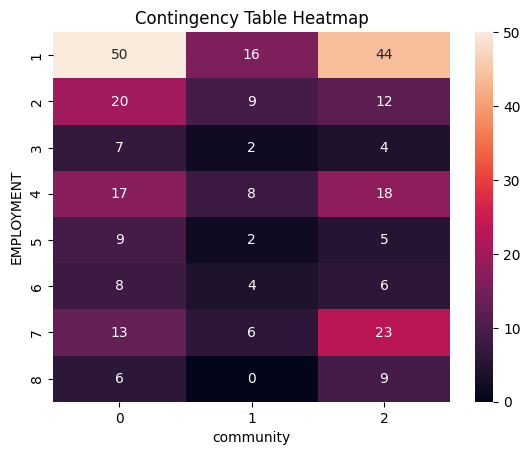

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [337]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    12.9908
Degrees of Freedom:       14
p-value:                  5.2725e-01

Expected Frequencies (rounded):
community       0      1      2
EMPLOYMENT                     
1           47.99  17.35  44.66
2           17.89   6.47  16.65
3            5.67   2.05   5.28
4           18.76   6.78  17.46
5            6.98   2.52   6.50
6            7.85   2.84   7.31
7           18.32   6.62  17.05
8            6.54   2.37   6.09


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [338]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    12.9908
Degrees of Freedom:       14
p-value:                  5.2725e-01

Expected Frequencies (rounded):
community       0      1      2
EMPLOYMENT                     
1           47.99  17.35  44.66
2           17.89   6.47  16.65
3            5.67   2.05   5.28
4           18.76   6.78  17.46
5            6.98   2.52   6.50
6            7.85   2.84   7.31
7           18.32   6.62  17.05
8            6.54   2.37   6.09

Standardized Residuals:
community      0     1     2
EMPLOYMENT                  
1           0.29 -0.32 -0.10
2           0.50  1.00 -1.14
3           0.56 -0.04 -0.56
4          -0.41  0.47  0.13
5           0.76 -0.33 -0.59
6           0.05  0.69 -0.48
7          -1.24 -0.24  1.44
8          -0.21 -1.54  1.18

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result**: 
Residuals: needs to be filled.

## 2. Dataset: responses stacked

In [339]:
# dataset
q2 = pd.read_json('~/thesis/data/processed_data/knowledge_q2_lemmatized.jsonl', orient='records', lines = True)

In [340]:
q2.head()

,participant_id,answer
0,00278,equal pay woman men role
1,00278,ensure woman voice heard
2,00278,woman equally considered promotion
3,00278,education sexual harassment
4,00278,woman seen equal men capable


In [341]:
# Step 4: Vectorize the concatenated responses using BoW
vectorizer = CountVectorizer(max_features=1000)
vectors2 = vectorizer.fit_transform(q2['answer']).toarray()

In [342]:
# Step 5: Create a DataFrame from the vectors
final_df = pd.DataFrame(vectors2, index=q2['participant_id'])

In [343]:
# Step 6: Convert final_df to a Gensim-compatible corpus format
corpus = [list(enumerate(doc)) for doc in final_df.values]

# Create a Gensim Dictionary using the vocabulary from the vectorizer
vocab = vectorizer.get_feature_names_out()
dummy_dict = corpora.Dictionary()
dummy_dict.token2id = {word: idx for idx, word in enumerate(vocab)}
dummy_dict.id2token = {idx: word for idx, word in enumerate(vocab)}

## Coherence Score to define num_topics parameter

In [344]:
from gensim.models import CoherenceModel

### warning: it takes long. Just be sure you need it.

In [346]:
# Function to compute coherence score
def compute_coherence_score(corpus, dictionary, texts, num_topics):
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Prepare texts for coherence computation
texts = [doc.split() for doc in q2['answer']]  # Assuming you have preprocessed texts

# Evaluate coherence score for different numbers of topics
num_topics_list = range(2, 15)
coherence_scores = []

for num_topics in num_topics_list:
    coherence_score = compute_coherence_score(corpus, dummy_dict, texts, num_topics)
    coherence_scores.append(coherence_score)
    print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')



Number of topics: 2, Coherence Score: 0.3149387775569541
Number of topics: 3, Coherence Score: 0.4632692806483149
Number of topics: 4, Coherence Score: 0.42918511243916935
Number of topics: 5, Coherence Score: 0.43334328646658465
Number of topics: 6, Coherence Score: 0.4885907040266282
Number of topics: 7, Coherence Score: 0.4740040613206956
Number of topics: 8, Coherence Score: 0.44143631683568285
Number of topics: 9, Coherence Score: 0.46240943676057356
Number of topics: 10, Coherence Score: 0.4743713374965914
Number of topics: 11, Coherence Score: 0.4834824361979408
Number of topics: 12, Coherence Score: 0.5049459221264142
Number of topics: 13, Coherence Score: 0.48797393950491574
Number of topics: 14, Coherence Score: 0.49671518067332227


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()


In [ ]:
# Step 7: Train the LDA model on the corpus
num_topics = 9  # Adjust based on your needs
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dummy_dict, passes=10)

In [ ]:
# Step 8: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dummy_dict)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, '/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics)+'.html')

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared


## Additional: 

In [79]:
from gensim.utils import simple_preprocess
from collections import Counter
from itertools import combinations
import pickle

In [80]:
# Extract top words for each topic
top_words_per_topic = []
for t in range(num_topics):
    top_words = [word for word, _ in lda_model.show_topic(t, topn=20)]
    top_words_per_topic.append(top_words)

In [81]:
top_words_per_topic

[['gender',
  'promotion',
  'salary',
  'company',
  'equal',
  'woman',
  'opportunity',
  'treat',
  'role',
  'give',
  'everyone',
  'regardless',
  'increase',
  'respect',
  'number',
  'encourage',
  'make',
  'ensure',
  'discussion',
  'equally'],
 ['people',
  'female',
  'male',
  'place',
  'gender',
  'leave',
  'policy',
  'number',
  'ensure',
  'employ',
  'higher',
  'equality',
  'training',
  'workplace',
  'equal',
  'review',
  'inequality',
  'parental',
  'employee',
  'position'],
 ['work',
  'gender',
  'training',
  'flexible',
  'child',
  'woman',
  'encourage',
  'allow',
  'group',
  'people',
  'sexism',
  'support',
  'working',
  'care',
  'incentive',
  'workplace',
  'equal',
  'offer',
  'issue',
  'diversity'],
 ['gender',
  'equality',
  'discrimination',
  'job',
  'role',
  'employee',
  'educate',
  'improve',
  'people',
  'work',
  'dont',
  'equal',
  'open',
  'application',
  'toilet',
  'ask',
  'workplace',
  'workshop',
  'specific',
  

In [82]:
# Compute co-occurrence matrix
def compute_cooccurrence_matrix(texts):
    word_counts = Counter(word for text in texts for word in text)
    total_count = sum(word_counts.values())
    word_pairs = Counter()
    for text in texts:
        for i, j in combinations(set(text), 2):
            word_pairs[tuple(sorted([i, j]))] += 1
    return word_pairs, word_counts, total_count

word_pairs, word_counts, total_count = compute_cooccurrence_matrix(data_words)

# Compute NPMI
def compute_npmi(word_pairs, word_counts, total_count):
    npmi_matrix = {}
    for (w_i, w_j), cooccur_count in word_pairs.items():
        p_i = word_counts[w_i] / total_count
        p_j = word_counts[w_j] / total_count
        p_ij = cooccur_count / total_count
        if p_ij > 0:
            pmi = np.log(p_ij / (p_i * p_j))
            npmi = pmi / -np.log(p_ij)
            npmi_matrix[(w_i, w_j)] = npmi
    return npmi_matrix

npmi_matrix = compute_npmi(word_pairs, word_counts, total_count)

In [83]:
# Calculate average NPMI for each topic
def average_npmi_for_topics(top_words_per_topic, npmi_matrix):
    topic_npmis = []
    for top_words in top_words_per_topic:
        npmis = [npmi_matrix.get(tuple(sorted([w_i, w_j])), 0) for w_i, w_j in combinations(top_words, 2)]
        if npmis:
            topic_npmi = np.mean(npmis)
            topic_npmis.append(topic_npmi)
    return np.mean(topic_npmis) if topic_npmis else 0

average_npmi = average_npmi_for_topics(top_words_per_topic, npmi_matrix)
print("Average NPMI for LDA topics:", average_npmi)

Average NPMI for LDA topics: 0.1430087968618129


**Interpretation**

High NPMI (close to 1): Indicates strong semantic coherence between words, meaning the words are likely to appear together in similar contexts. This is generally considered good for topics generated by models like LDA.

NPMI around 0: Indicates that the words appear together about as frequently as expected by chance, suggesting neutral association.

Low NPMI (negative values): Indicates that the words are unlikely to appear together, suggesting poor coherence for the topic.